# 1. Objective:

1. Fine-tune the model​:<br> 
a. Reiterate the modelling process keeping in mind the areas of improvement <br>
b. Highlight and provide commentary on the steps taken to arrive at the improved model <br><br>
  
2. Interpretation and Recommendations:<br>
a. Provide interpretations from the model and report the final model evaluation metrics <br>
b. Report the recommendations, summarize the project and mention identified next steps <br><br>

<font color='blue' size=4><b>1.1 Import libraries<b>

In [4]:
import os
import io

import pandas as pd
import numpy as np
import random

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import skimage.io as io
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage import measure

import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout, InputLayer, BatchNormalization, Input
from tensorflow.keras.layers import LeakyReLU, SpatialDropout2D, MaxPool2D
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, ZeroPadding2D, DepthwiseConv2D, Conv2DTranspose, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers


%matplotlib inline

<font color='blue' size=4><b>1.2 Initialize the variables

In [5]:
#Initialize the variables

input_dir = 'input'
output_dir = 'output'
input_train = 'stage_2_train_images'
input_test = 'stage_2_test_images'
class_file = 'stage_2_detailed_class_info.csv'
label_file = 'stage_2_train_labels.csv'
output_train = 'train'
output_test = 'test'
output_val = 'val'

root_dir = 'data' #os.path.join('..', 'input', 'rsna-pnemonia-processed')

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

<font color='blue' size=4><b>1.3 Load the Training, Validation and Test file names from the folder structure.

In [6]:
#initialize folders train, val , test, directory
output_dir = os.path.join(root_dir, output_dir)
 
train_dir = os.path.join(output_dir,output_train)
val_dir = os.path.join(output_dir,output_val)
test_dir = os.path.join(output_dir, output_test)

# Get a list of train, test and val images to create a datagenerator
train_list = (os.listdir(train_dir))
val_list = (os.listdir(val_dir))
test_list = (os.listdir(test_dir))

num_train_samples = len(os.listdir(train_dir))
num_val_samples = len(os.listdir(val_dir))
num_test_samples = len(os.listdir(test_dir))

train_batch_size = 10
val_batch_size = 10

#initialize the training and validation steps
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

print ('Training sample size: ', num_train_samples)
print ('Training steps: ', train_steps)
print ('Validation sample size: ', num_val_samples)
print ('Validation steps : ', val_steps)
print ('Testing sample size: ', num_test_samples)

Training sample size:  24310
Training steps:  2431.0
Validation sample size:  2995
Validation steps :  300.0
Testing sample size:  3000


<font color='blue'><b><font size=4>1.4 Custom Generator class</b></font><br>
<font color='blue' size=3>
Adapted the class (initially defined in second submission) to return multiple label information that can support both classification and segmentation. The possible return values are:
1. Masked image with embedded bounding box .
2. One-hot-encoded classification label, which indicates only 2 classifications: Normal or Pneumonia.
3. Both of the above information.

This adaptation is motivated to exploit the faster R-CNN model which expects classification and segmentation labels. 

In [7]:
# Generator class which handles large dataset and creates batches of images.
class generator(tf.keras.utils.Sequence):
    
    def __init__(self, img_dir,label_file,  batch_size=32, image_size=256, shuffle=True, augment=False, predict=False, ytype=['box','lbl', 'both']):
        """
        Args:
        :param img_dir (string): Directory with all the images(train, val or test)
        :param batch_size (optional): Defines the batch size of the generator. when the value is increased memory usage will be more. default is 32.
        :param image_size: Imagesize which will be input to the model. Images will be loaded to memory and resized them to this resize before inputting to model. default is 256
        :param shuffle (optional): defult is True, when True the dataset is shuffled before each epoch.
        :param augment (optional): defult is False, when True the dataset is flipped horizontally
        :param predict (optional): defult is False, when True only the images are returned , When False, Images and its masks are returned
        :param ytype : List of possible values=['box','lbl', 'both']. box - returns only the boundarybox as ylable, lbl - returns only the classification lable, both - returns both.
        """
        self.folder = img_dir
        self.filenames = os.listdir(img_dir)
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.ytype = ytype
        self.on_epoch_end()
        # read the label Label file which contains the bounding boxes
        self.df_data = pd.read_csv(label_file)
        # set Nan values to 0
        self.df_data= self.df_data.fillna(0)
        self.ratio = image_size / 1024 # Original size
        
    def __load__(self, filename):
        # load input png image file as numpy array
        img = cv2.imread(os.path.join(self.folder ,filename), 0) 
        # create empty mask
        msk = np.zeros((self.image_size, self.image_size))
        patient = self.df_data[self.df_data.patientId==filename[:-4]]
        #initialize the lable
        lungopacity = [1,0] # Normal
        for i in range(len(patient)):
            #Calculate the bounding box based on the resized image
            x1 = int(self.ratio * patient['x'].iloc[i]  )
            y1 = int(self.ratio * patient['y'].iloc[i] )
            x2 = x1 + int(self.ratio * patient['width'].iloc[i] )
            y2 = y1 + int(self.ratio * patient['height'].iloc[i])
            msk[y1:y2, x1:x2] = 1
            if ((x2 - x1) > 0) & ((y2 - y1) >0):
                lungopacity = [0,1] # update the labels to Pneumonia
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size, 1), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
#         img = np.expand_dims(img, -1)
#         msk = np.expand_dims(msk, -1)
        return img, lungopacity,msk
    
    def __loadpredict__(self, filename):
        # load png image file as numpy array
        img = cv2.imread(os.path.join(self.folder ,filename), 0) 
        # resize image
        img = resize(img, (self.image_size, self.image_size, 1), mode='reflect')
        # add trailing channel dimension
#         img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batches of files
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs#, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__( filename) for filename in filenames]
            # unzip images and masks
            imgs, lbls, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            lbls = np.array(lbls)
            if self.ytype == 'box':
                return imgs, msks
            elif self.ytype == 'lbl':
                return imgs, lbls
            else:    
                return imgs, [lbls, msks]
            
    def on_epoch_end(self):
        if self.shuffle:
            shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

<font color='blue' ><font size=4><b>1.5 Create generator objects</b></font><br>

Create 2 sets of generator object for Train, Validation and Test:
1. Generator which provides both classification and segmentation labels.
2. Generator which provides only segmentation labels.


In [8]:
# create Image generator for train, validation and test images
# label_path = os.path.join(root_dir, input_dir, label_file)
label_path = os.path.join(os.path.join('..', 'input', 'rsna-pneumonia-detection-challenge', label_file))
train_gen_both = generator(train_dir, label_path, batch_size=32, image_size=IMAGE_HEIGHT, shuffle=True, augment=True, predict=False, ytype='both')
val_gen_both = generator(val_dir,label_path,  batch_size=32, image_size=IMAGE_HEIGHT, shuffle=False, predict=False, ytype='both')
test_gen_both = generator(test_dir, label_path, batch_size=32, image_size=IMAGE_HEIGHT, shuffle=False, predict=True, ytype='both')

In [9]:
# create Image generator for train, validation and test images
# label_path = os.path.join(root_dir, input_dir, label_file)
label_path = os.path.join(os.path.join('..', 'input', 'rsna-pneumonia-detection-challenge', label_file))
train_gen = generator(train_dir, label_path, batch_size=32, image_size=IMAGE_HEIGHT, shuffle=True, augment=True, predict=False, ytype='box')
val_gen = generator(val_dir,label_path,  batch_size=32, image_size=IMAGE_HEIGHT, shuffle=False, predict=False, ytype='box')
test_gen = generator(test_dir, label_path, batch_size=32, image_size=IMAGE_HEIGHT, shuffle=False, predict=True, ytype='box')

<font color='blue' ><font size=4><b>1.6 Function to detect Boundaries</b></font><br>
This function detects lung opacity boundaries from true and predicted masked images. For the given 'axis' information,  bounding boxes are drawn on the original image. Blue color bounding boxes are drawn for true boundaries , Red color bounding boxes are used for predicted boundaries.

In [10]:
# In the mask, find the bounding box, if there is one then the image consist of Pneumonia infection
def detectandMask(mask_img, pred = True, ax=None):
    comp = mask_img[:, :] > 0.5
    # apply connected components
    comp = measure.label(comp)
    regionFound_true = 0
    # apply bounding boxes
    for region in measure.regionprops(comp):
        color = 'b'
        if (pred == True):
            color = 'r'
        try:
            y, x, y2, x2 = region.bbox
            
        except:
            y, x,_, y2, x2 ,_= region.bbox
            
        height = y2 - y
        width = x2 - x
        if ax != None:
            ax.add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor=color,facecolor='none'))
        #Ignore small patches
        if (width > 10) & (height > 10):
            regionFound_true = 1

    return regionFound_true

<font color='blue'><b>1.7 Define Different Losses:<br></b>
*     ${\displaystyle DiceCoefficient={\frac {2|X\cap Y|}{|X|+|Y|}}}$
*     ${\displaystyle IoU={\frac {|X\cap Y|}{|X \cup Y|}}}$


In [11]:
# Define Dice coefficient
def dice_coefficient(y_true, y_pred):
    numerator = 2.0 *  tf.reduce_sum(y_true * y_pred) 
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon() ) 

# Combine Bce loss and dice coefficient
def loss(y_true, y_pred):
    y_true = tf.dtypes.cast(y_true, tf.float32)
    y_pred = tf.dtypes.cast(y_pred, tf.float32)
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

# Iou loss
def iou_loss(y_true, y_pred):
    y_true = tf.dtypes.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred = tf.dtypes.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# define mean iou 
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# Pixel accuracy
accu = tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)


# 2. Fine-tune the model​:

1. Reiterate the modelling process keeping in mind the areas of improvement
2. Highlight and provide commentary on the steps taken to arrive at the improved model

<font color='blue'>In continuation from my previous submission, I adapted the following parameter to improve evaluation metrics:
1. Learning rate : I had tried increasing and decreasing the rate between 0.1 - 0.00001, but there was no significant change in the model's performance. <br>
Loss & Activation functions: With different combination of Loss(IOU, binary crossentropy), Activation (adam, sgd and rmpsprop), there were no improvement in the performance. For further reference, I have attached few of my trials as supporting documents. <br> From this, I conclude that the hyperparameter which was used in my previous submission(Learning rate= 0.01, Activation: adam and Loss:IoU) performs better. 

2. Network adaptations: Investigate transfer learning and adding additional layers.

3. Additional model architecture : Investigate faster R-CNN, Resnet and Yolo, as suggested by Mentor

<font color='blue' ><font size=4>2.1 Load the base UNet model</b></font><br>

Base UNet Model which was trained in my Project Notes2 submission.
* Input : takes 224 X 224 grayscale images  <br>
* Output : predicts masked grayscale image of size 224 X 224 .<br>
* Gray scale image was chosen to reduce the memory consumption. To keep my model simple,  I used RELU as activation function and simple Convolution layer. Initally i had created model without normalization, later had included to improve the performance. As final layer, I had used sigmoid activation.  <br>
    
I had trained this model for 15 epochs. I have loaded the pretrained weights( Weight file is baseunet_e15.h5). This model can be used to further transfer learning. With this way, I could save the time in training.
    

In [9]:
def createBaseModel():
    input_l = Input((IMAGE_HEIGHT, IMAGE_WIDTH, 1), name = 'input_1')
    #Contraction Path
    layer0 =Conv2D(64, (3, 3), activation='relu', padding="same")(input_l)
    b0 = BatchNormalization()(layer0)
    mp0 = MaxPooling2D(pool_size=(2, 2))(b0)

    layer1 =Conv2D(32, (3, 3), activation='relu', padding="same")(mp0)
    b1 = BatchNormalization()(layer1)
    mp1 = MaxPooling2D(pool_size=(2, 2))(b1)

    layer2 = Conv2D(64, (3, 3), activation='relu', padding="same")(mp1)
    b2 = BatchNormalization()(layer2)
    mp2 = MaxPooling2D(pool_size=(2, 2))(b2)

    layer3 = Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same")(mp2)
    b3 = BatchNormalization()(layer3)
    mp3 = MaxPooling2D(pool_size=(2, 2))(b3)

    layer4 = Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same")(mp3)
    b4 = BatchNormalization()(layer4)
    mp4 = MaxPooling2D(pool_size=(2, 2))(b4)    
    #Expansion path
    up4 = Conv2D(128, (3, 3), dilation_rate=(2, 2), activation = 'relu', padding = 'same')(UpSampling2D()(mp4))
    merge4 = Concatenate()([layer4,up4])
    
    up3 = Conv2D(96, (3, 3), dilation_rate=(2, 2), activation = 'relu', padding = 'same')(UpSampling2D()(merge4))
    merge3 = Concatenate()([layer3,up3])
    
    up2 = Conv2D(64, (3, 3),  activation = 'relu', padding = 'same')(UpSampling2D()(merge3))
    merge2 = Concatenate()([layer2,up2])
    
    up1= Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D()(merge2))
    merge1 = Concatenate()([layer1,up1])
    
    up0 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D()(merge1))
    merge0 = Concatenate(name ='concat_last')([layer0,up0])
   
    
    
    convl = Conv2D(1, kernel_size=1, activation='sigmoid') (merge0)
    
    outputs = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(convl)
    
    return  Model(inputs=[input_l], outputs=[outputs]) 

baseunetmodel = createBaseModel()
baseunetmodel.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
# Loading the stored weights.
baseunetmodel.load_weights('baseunet_e15.h5')

<font color='blue'>
Fetch input layer to the base model and the last layer of the unet model (concat_last). This layers can be used as inut for my transfer learning. I can decide either to train all the layers again or use the pretrained layers and train only the additional layers. This will speed up the training time. As opf now I will freeze the base model weights</font>

In [11]:
for layer in baseunetmodel.layers:
    baseunetmodel.trainable = False
    
inputtransfer = baseunetmodel.get_layer('concat_last').output
input_1 = baseunetmodel.get_layer('input_1').input

<font color='blue' ><font size=4>Build classification model</b></font><br>
Classification model consists of the following layer.
1. Four Conv2D layers to build a deeper model 
2. Increased number of filters to learn more features
3. Added Dropout layers for regularization
4. Added final Dense layers

In [12]:
def getClassificationLayer(inputl):
    num_classes = 2 #(Normal, Pneumonia)

    #Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'ReLU' 
    layer = Conv2D(32, kernel_size=(3, 3),
                 activation='relu',name='conv_1')(inputl)

    #Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
    layer = Conv2D(64, (3, 3), activation='relu',name='conv_2')(layer)

    #Add a MaxPooling Layer of size 2X2 
    layer =MaxPooling2D(pool_size=(2, 2),name='max_1')(layer)

    #Apply Dropout with 0.25 probability 
    layer = Dropout(0.25,name='drop_1')(layer)

    #Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'ReLU' 
    layer = Conv2D(32, kernel_size=(3, 3),
                 activation='relu',name='conv_3')(layer)

    #Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
    layer = Conv2D(64, (3, 3), activation='relu',name='conv_4')(layer)

    #Add a MaxPooling Layer of size 2X2 
    layer =MaxPooling2D(pool_size=(2, 2),name='max_2')(layer)

    #Apply Dropout with 0.25 probability 
    layer = Dropout(0.25,name='drop_2')(layer)

    #Flatten the layer
    layer =Flatten()(layer)

    #Add Fully Connected Layer with 128 units and activation function as 'ReLU'
    layer = Dense(128, activation='relu',name='dense_1')(layer)

    #Apply Dropout with 0.5 probability 
    layer = Dropout(0.5,name='drop_3')(layer)

    #Add Fully Connected Layer with 10 units and activation function as 'softmax'
    layer = Dense(num_classes, activation='softmax',name='dense_2') (layer)
    
    return layer

<font color='blue' ><b><font size=4>Build Segmentation model</font></b><br>
    Base UNet model performs image segmentation. Adding more Con2D layers and filters for deeper model

In [13]:
def getSegmentationLayer(input):
    #Add 2 Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
    layer = Conv2D(64, (3, 3), activation='relu', padding="same")(input)
    layer = Conv2D(64, (3, 3), activation='relu', padding="same")(layer)

    layer = Conv2D(1, kernel_size=1, activation='sigmoid')(layer)
    # Reshape them to the mask size. I get better result with this and binary accuraccy
    layer = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(layer)
    
    return layer

<font color='blue' ><font size=4><b>Initialize the Callbacks</b></font><br>
    Initialize the ModelCheckpoint, Earlystopping and ReduceLROnPlateau

In [12]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
stop = EarlyStopping(monitor="val_accuracy", patience=5, mode="max")
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.001)
                              
                              
callbacks_list = [checkpoint , reduce_lr, stop]

<font color='blue' ><font size=4><b>Base UNet Model</b></font><br>
Load the pretrained weights

In [15]:
#Loading the weights instead of training again.
baseunetmodel = createBaseModel()
baseunetmodel.load_weights('baseunet_e15.h5')

In [16]:
# optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# baseunetmodel.compile(optimizer='adam',
#           loss=iou_loss,
#           metrics=[accu, mean_iou])
# #fit the model for 5 epoch.
# history = baseunetmodel.fit(train_gen,
#                        validation_data=val_gen,
#                        epochs=1,
#                        verbose=1,
#           callbacks=callbacks_list
# )

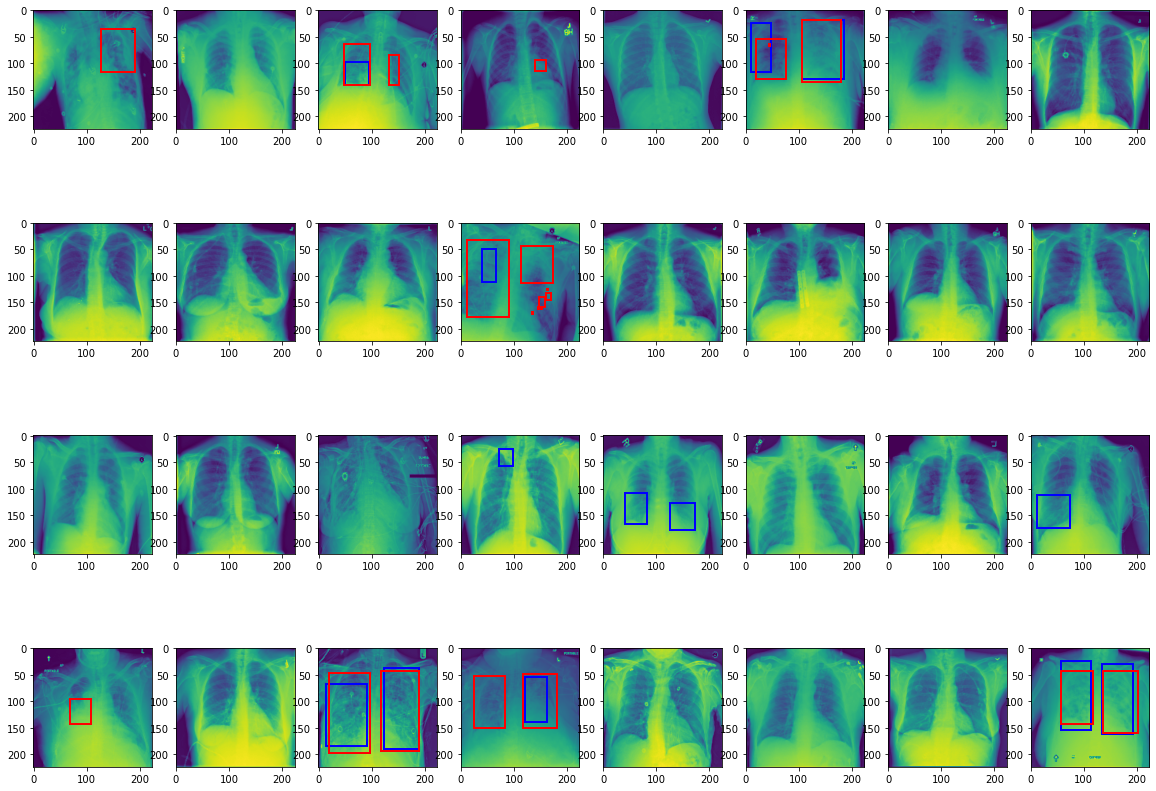

In [17]:
for imgs, msks in val_gen:
    # predict batch of images
    preds = baseunetmodel.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img,msk, predm in zip(imgs,msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        detectandMask(msk,False, axarr[axidx])
        detectandMask(predm,True, axarr[axidx])
        axidx += 1
    plt.show()
    
    # only plot one batch
    break

<font color='blue' >Above results are from base UNet model which generates 97% accuracy. As mentioned, I will perform simple transfer learning techniques.

<font color='blue' ><font size=4><b>Transfer Learning 1:</b></font><br>
    Extending the base UNet model with additional convolution layer. Freezing the base layers while training new layers.

In [18]:
#Initialize the model again
baseunetmodel = createBaseModel()
baseunetmodel.load_weights('baseunet_e15.h5')
inputtransfer = baseunetmodel.get_layer('concat_last').output
input_1 = baseunetmodel.get_layer('input_1').input

for layer in baseunetmodel.layers:
    baseunetmodel.trainable = False
cnnmodel_tl1 =  Model(inputs=[input_1], outputs=[getSegmentationLayer(inputtransfer)]) 
cnnmodel_tl1.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 224, 224, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 224, 224, 64) 256         conv2d_22[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 112, 112, 64) 0           batch_normalization_10[0][0]     
_______________________________________________________________________________________

In [19]:
cnnmodel_tl1.compile(optimizer='adam',
          loss=iou_loss,
          metrics=[accu, mean_iou])
#fit the model for 5 epoch.
history = cnnmodel_tl1.fit(train_gen,
                       validation_data=val_gen,
                       epochs=5,
                       verbose=1,
          callbacks=callbacks_list
)

Epoch 1/5
759/759 [==============================] - 638s 840ms/step - loss: 0.6171 - binary_accuracy: 0.9745 - mean_iou: 0.7346 - val_loss: 0.5842 - val_binary_accuracy: 0.9659 - val_mean_iou: 0.6893
Epoch 2/5
759/759 [==============================] - 544s 717ms/step - loss: 0.6174 - binary_accuracy: 0.9744 - mean_iou: 0.7347 - val_loss: 0.5839 - val_binary_accuracy: 0.9658 - val_mean_iou: 0.6891
Epoch 3/5
759/759 [==============================] - 527s 694ms/step - loss: 0.6200 - binary_accuracy: 0.9743 - mean_iou: 0.7332 - val_loss: 0.5841 - val_binary_accuracy: 0.9659 - val_mean_iou: 0.6912
Epoch 4/5
759/759 [==============================] - 512s 675ms/step - loss: 0.6184 - binary_accuracy: 0.9744 - mean_iou: 0.7357 - val_loss: 0.5841 - val_binary_accuracy: 0.9659 - val_mean_iou: 0.6906
Epoch 5/5
759/759 [==============================] - 521s 687ms/step - loss: 0.6194 - binary_accuracy: 0.9743 - mean_iou: 0.7338 - val_loss: 0.5838 - val_binary_accuracy: 0.9656 - val_mean_iou: 0.

In [29]:
# Store the weights
cnnmodel_tl1.save_weights('cnnmodel_tl1.h5')

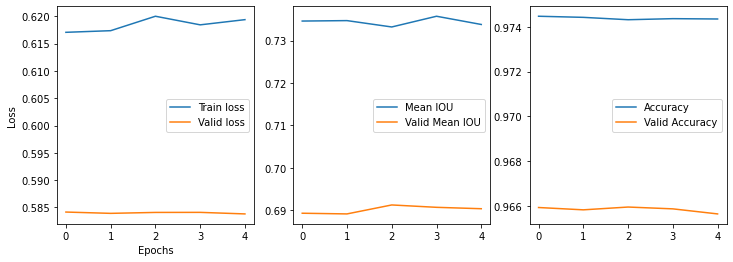

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(131)
history = cnnmodel_tl1.history

plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.plot(history.epoch, history.history["mean_iou"], label="Mean IOU")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid Mean IOU")
plt.legend()

plt.subplot(133)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Accuracy")
plt.legend()

plt.show()

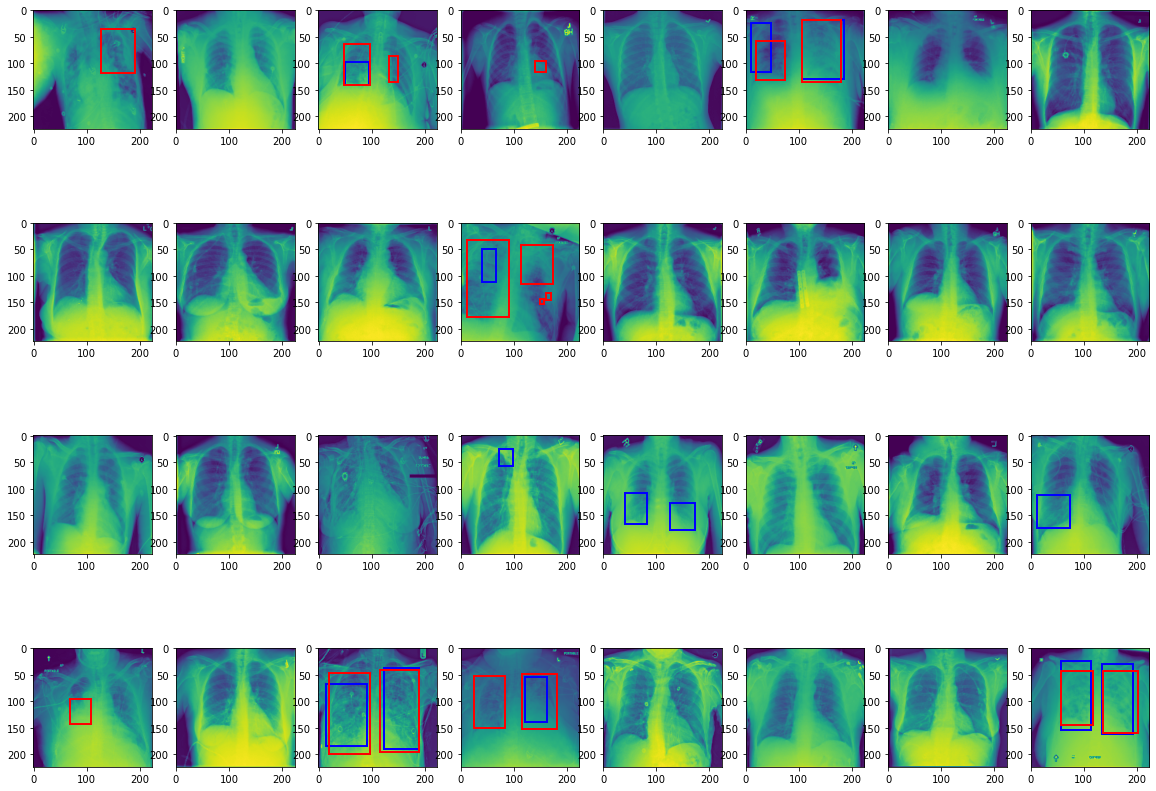

In [21]:
for imgs, msks in val_gen:
    # predict batch of images
    preds = cnnmodel_tl1.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img,msk, predm in zip(imgs,msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        detectandMask(msk,False, axarr[axidx])
        detectandMask(predm,True, axarr[axidx])
        axidx += 1
    plt.show()
    
    # only plot one batch
    break

<font color='blue'>From the above, I infer that the output looks similar to the basemodel. Since I have freezed the base layers, this model didnt learn additionally. I will try to learn the model by training all the layers.

<font color='blue' ><font size=4><b>Transfer Learning 2:</b></font><br>
    Extending the base UNet model which can identify both segmentation and classification. Before creating complex yolo or faster-RCNN model, I wanted to verify a simple model which can predict both segmentaion and classification performs. As inital step, I am creating this model without ROI layer. I had loaded the pretrained weights, still would train the base layer again.
    Note: I will not consider this model for final analysis.

In [22]:
#Initialize the model again
baseunetmodel = createBaseModel()
baseunetmodel.load_weights(baseunet_e15.h5')
inputtransfer = baseunetmodel.get_layer('concat_last').output
input_1 = baseunetmodel.get_layer('input_1').input

for layer in baseunetmodel.layers:
    baseunetmodel.trainable = True
    
cnnmodel_tl2 =  Model(inputs=[input_1], outputs=[getClassificationLayer(inputtransfer), getSegmentationLayer(inputtransfer)]) 
cnnmodel_tl2.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 224, 224, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 224, 224, 64) 256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 112, 112, 64) 0           batch_normalization_15[0][0]     
______________________________________________________________________________________

In [23]:
# Adam optimizer
# loss function will be iou and bce loss
# evaluation metric will be accuracy and mean iou

cnnmodel_tl2.compile(loss=['categorical_crossentropy', iou_loss],
optimizer= 'adam',
metrics=[ 'accuracy', accu])

#fit the model for 5 epoch.
history = cnnmodel_tl2.fit(train_gen_both,
                       validation_data=val_gen_both,
                       epochs=5,
                       verbose=1,
          callbacks=callbacks_list
)

Epoch 1/5
759/759 [==============================] - 570s 752ms/step - loss: 1.8522 - dense_2_loss: 1.2224 - reshape_5_loss: 0.6298 - dense_2_accuracy: 0.8315 - dense_2_binary_accuracy: 0.8315 - reshape_5_accuracy: 0.0479 - reshape_5_binary_accuracy: 0.9727 - val_loss: 1.1709 - val_dense_2_loss: 0.5821 - val_reshape_5_loss: 0.5889 - val_dense_2_accuracy: 0.8199 - val_dense_2_binary_accuracy: 0.8199 - val_reshape_5_accuracy: 0.0100 - val_reshape_5_binary_accuracy: 0.9659
Epoch 2/5
759/759 [==============================] - 576s 758ms/step - loss: 0.9752 - dense_2_loss: 0.3673 - reshape_5_loss: 0.6079 - dense_2_accuracy: 0.8462 - dense_2_binary_accuracy: 0.8462 - reshape_5_accuracy: 0.0208 - reshape_5_binary_accuracy: 0.9757 - val_loss: 1.1364 - val_dense_2_loss: 0.5380 - val_reshape_5_loss: 0.5984 - val_dense_2_accuracy: 0.8236 - val_dense_2_binary_accuracy: 0.8236 - val_reshape_5_accuracy: 0.0247 - val_reshape_5_binary_accuracy: 0.9676
Epoch 3/5
759/759 [==============================]

In [28]:
# Store the weights
cnnmodel_tl2.save_weights('cnnmodel_tl2.h5')

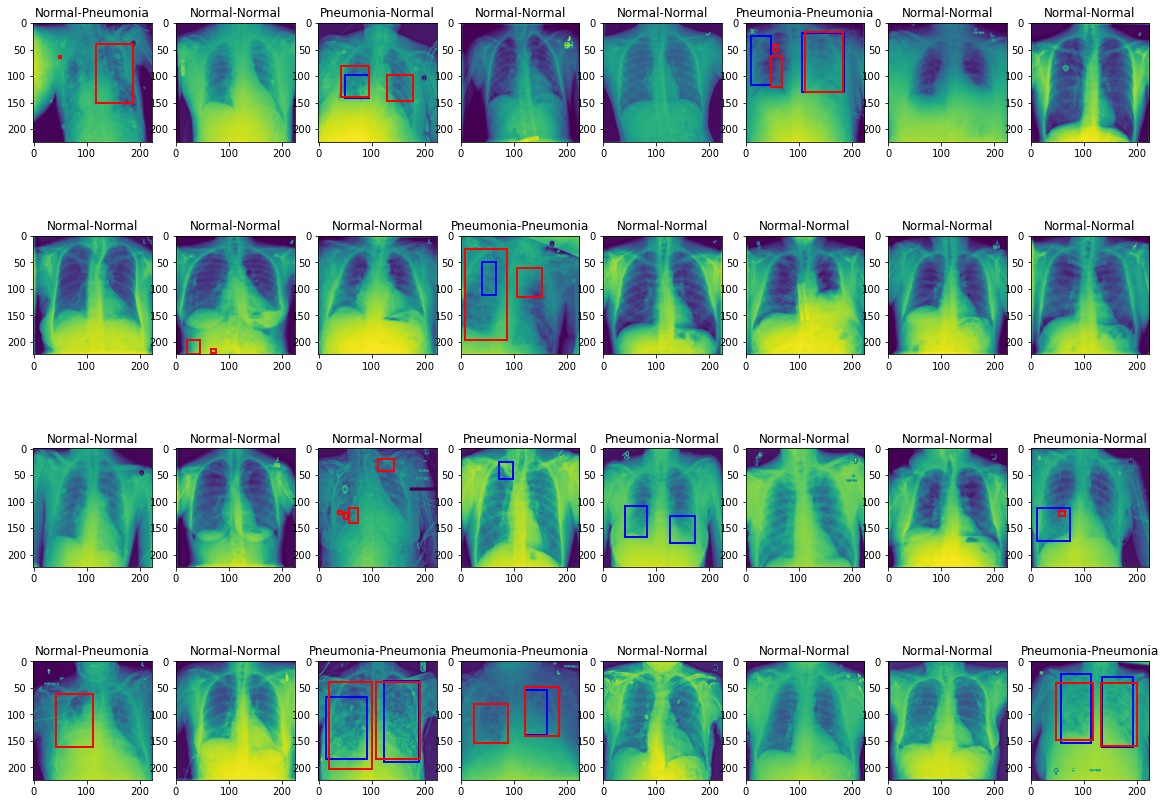

In [24]:
from skimage import measure

y_true = []
y_pred = []
for imgs, msks in val_gen_both:
    msks
    # predict batch of images
    preds = cnnmodel_tl2.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img,lbl, msk, predl,predm in zip(imgs,msks[0], msks[1], preds[0], preds[1]):
        
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        detectandMask(msk,False, axarr[axidx])
        detectandMask(predm,True, axarr[axidx])
        axarr[axidx].set_title(('Pneumonia' if np.argmax(lbl) ==1 else 'Normal') + '-' + ('Pneumonia' if np.argmax(predl) ==1 else 'Normal'))
        y_true.append(np.argmax(lbl))
        y_pred.append(np.argmax(predl))
        axidx += 1
    plt.show()
    
    # only plot one batch
    break

<font color='blue'>Above model predicts both classification and as well as segmentation.<br>
Segmentation orignal area and predicted area is printed on the image. Since the base layers are frozen the segmentation results looks same as the base model. <br>
Classification orginal and prediction is printed as title for each image (Original - Predicted). In few cases the Classification prediction didnt match with the original. I will produce the evaluation metrics to get complete insights. <br>

Compared to the other model this model identifies pneumonia infection outside the lung area. So I will not further analyse this model.


<font color='blue' ><font size=4><b>ResNet Model:</b></font><br>

This Model consists of 4 deep layers of Resnet Block

In [25]:
from tensorflow.keras.layers import add

def create_downsample(channels, inputs):
    layer = BatchNormalization(momentum=0.9)(inputs)
    layer = LeakyReLU(0)(layer)
    layer = Conv2D(channels, 1, padding='same', use_bias=False)(layer)
    layer = MaxPool2D(2)(layer)
    return layer

def create_resblock(channels, inputs):
    layer = BatchNormalization(momentum=0.9)(inputs)
    layer = LeakyReLU(0)(layer)
    layer = Conv2D(channels, 3, padding='same', use_bias=False,activity_regularizer=regularizers.l2(0.001))(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = LeakyReLU(0)(layer)
    layer = Conv2D(channels, 3, padding='same', use_bias=False,activity_regularizer=regularizers.l2(0.001))(layer)
    return add([layer, inputs])

def createResnetModel():
    # input
    channels= 32
    depth = 4
    n_blocks = 2
    # Input layer
    inputs = Input(shape=(224, 224, 1))
    layer = Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        layer = create_downsample(channels, layer)
        for b in range(n_blocks):
            layer = create_resblock(channels, layer)
    # output
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = LeakyReLU(0)(layer)
    layer = Conv2D(256, 1, activation=None)(layer)
    layer = SpatialDropout2D(0.25)(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = LeakyReLU(0)(layer)
    layer = Conv2DTranspose(128, (8,8), (4,4), padding="same", activation=None)(layer)
    layer = SpatialDropout2D(0.25)(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = LeakyReLU(0)(layer)
    layer = Conv2D(1, 1, activation='sigmoid')(layer)
    outputs = UpSampling2D(2**(depth-2))(layer)
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model

resnetmodel = createResnetModel()
resnetmodel.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 224, 224, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 224, 224, 32) 128         conv2d_50[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 224, 224, 32) 0           batch_normalization_20[0][0]     
______________________________________________________________________________________

In [26]:
# create compiler
resnetmodel.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy', mean_iou])

#fit the model for 5 epoch.
history = resnetmodel.fit(train_gen,
                       validation_data=val_gen,
                       epochs=5,
                       verbose=1,
          callbacks=callbacks_list
)


Epoch 1/5
759/759 [==============================] - ETA: 0s - loss: 160.2630 - accuracy: 0.9326 - mean_iou: 0.3352
Epoch 00001: val_accuracy improved from -inf to 0.95904, saving model to model.h5
759/759 [==============================] - 594s 782ms/step - loss: 160.2630 - accuracy: 0.9326 - mean_iou: 0.3352 - val_loss: 111.1469 - val_accuracy: 0.9590 - val_mean_iou: 0.6910
Epoch 2/5
759/759 [==============================] - ETA: 0s - loss: 176.1188 - accuracy: 0.9387 - mean_iou: 0.3414
Epoch 00002: val_accuracy did not improve from 0.95904
759/759 [==============================] - 584s 770ms/step - loss: 176.1188 - accuracy: 0.9387 - mean_iou: 0.3414 - val_loss: 80.2697 - val_accuracy: 0.9418 - val_mean_iou: 0.3811
Epoch 3/5
759/759 [==============================] - ETA: 0s - loss: 288.2395 - accuracy: 0.9296 - mean_iou: 0.2361
Epoch 00003: val_accuracy did not improve from 0.95904

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.001.
759/759 [=========================

In [27]:
# Store the weights
resnetmodel.save_weights('resnetmodel.h5')

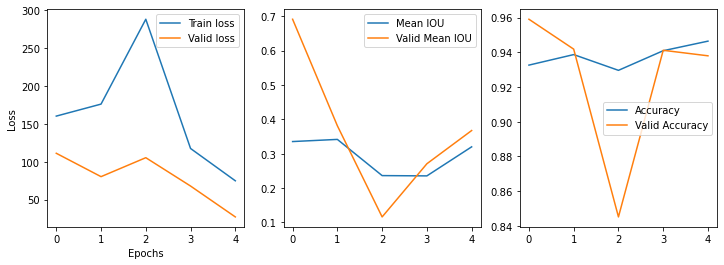

In [31]:
plt.figure(figsize=(12,4))
plt.subplot(131)
history = resnetmodel.history

plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.plot(history.epoch, history.history["mean_iou"], label="Mean IOU")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid Mean IOU")
plt.legend()

plt.subplot(133)
plt.plot(history.epoch, history.history["accuracy"], label="Accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid Accuracy")
plt.legend()

plt.show()

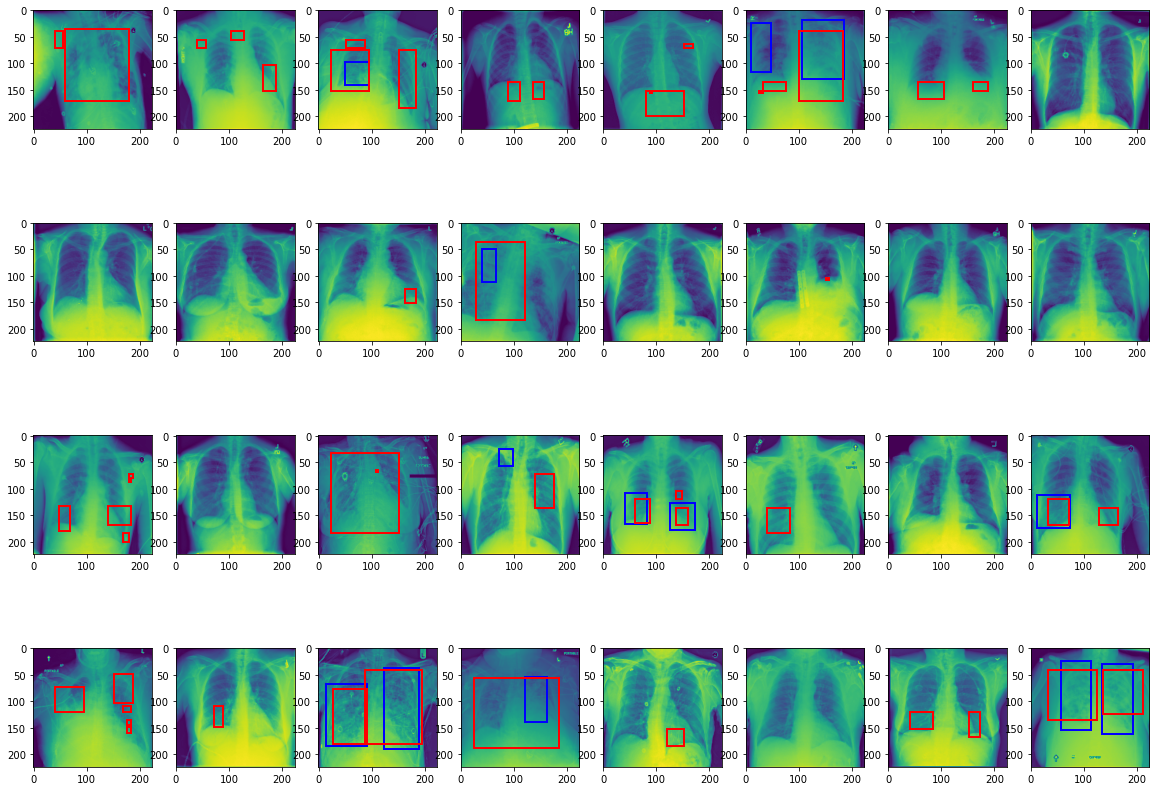

In [32]:
for imgs, msks in val_gen:
    # predict batch of images
    preds = resnetmodel.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img,msk, predm in zip(imgs,msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        detectandMask(msk,False, axarr[axidx])
        detectandMask(predm,True, axarr[axidx])
        axidx += 1
    plt.show()
    
    # only plot one batch
    break

<font color='blue' ><font size=3>From the above results, I infer that this resnet model is identifying it wrongly. If I finetune the model by increasing the resnet block or increase the epochs, it could produce better result. Due to my resource limitation, I will not pursue it further. Before further analyse, I will try to create deep UNET model and verify the results.</font>

<font color='blue' ><font size=3><b>Deep UNET Model:</b></font><br>

Since the Base Unet model performance is better compared to the other model, I will try to create Unet model with deeper convolution blocks. I have used 8 layers for each level. Each layer consists of Conv2D, BatchNormalization and Relu Activation layer.

In [18]:
# Create the following block of layers
# Convolution layer with given kernal size and filter. 
# If requested adds Batch norm layer 
# ReLu activation layer
# These convolution locks ared added 'ndeeplayer' times to create a deepConvolution layer.
def convolutionBlock(input_tensor,ndeeplayer, nfilters, kernelsize=3, batchnorm=True):
    layer = input_tensor
    
    for n in np.arange(ndeeplayer):
        # first layer
        layer = Conv2D(filters=nfilters, kernel_size=(kernelsize, kernelsize), kernel_initializer="he_normal",
                   padding="same")(layer)
        if batchnorm:
            layer = BatchNormalization()(layer)
        layer = Activation("relu")(layer)
    
    return layer

In [19]:
#This function creates Unet model with deep convolution layer.
def createUNETModel():
    input_img = Input((IMAGE_HEIGHT, IMAGE_WIDTH, 1), name = 'input_1')
    ndeeplayer=8
    nfilters=16
    dropout=0.5
    batchnorm=True
    # contracting path
    layer0 = convolutionBlock(input_img, ndeeplayer=ndeeplayer, nfilters=16, kernelsize=3, batchnorm=batchnorm)
    tmplayer = MaxPooling2D((2, 2)) (layer0)
    tmplayer = Dropout(dropout*0.5)(tmplayer)
    
    layer1 = convolutionBlock(tmplayer, ndeeplayer=ndeeplayer, nfilters=32, kernelsize=3, batchnorm=batchnorm)
    tmplayer = MaxPooling2D((2, 2)) (layer1)
    tmplayer = Dropout(dropout*0.5)(tmplayer)

    layer2 = convolutionBlock(tmplayer, ndeeplayer=ndeeplayer, nfilters=64, kernelsize=3, batchnorm=batchnorm)
    tmplayer = MaxPooling2D((2, 2)) (layer2)
    tmplayer = Dropout(dropout)(tmplayer)

    layer3 = convolutionBlock(tmplayer,ndeeplayer=ndeeplayer, nfilters=96, kernelsize=3, batchnorm=batchnorm)
    tmplayer = MaxPooling2D((2, 2)) (layer3)
    tmplayer = Dropout(dropout)(tmplayer)

    layer4 = convolutionBlock(tmplayer,ndeeplayer=ndeeplayer, nfilters=128, kernelsize=3, batchnorm=batchnorm)
    tmplayer = MaxPooling2D(pool_size=(2, 2)) (layer4)
    tmplayer = Dropout(dropout)(tmplayer)
    
    layer5 = convolutionBlock(tmplayer, ndeeplayer= ndeeplayer, nfilters=256, kernelsize=3, batchnorm=batchnorm)
    
    # expansive path
    tmplayer = Conv2D(128, (3, 3), dilation_rate=(2, 2), activation = 'relu', padding = 'same')(UpSampling2D()(layer5))
    tmplayer = Concatenate()([layer4,tmplayer])
    tmplayer = Dropout(dropout)(tmplayer)
    tmplayer = convolutionBlock(tmplayer, ndeeplayer=ndeeplayer, nfilters=128, kernelsize=3, batchnorm=batchnorm)

    tmplayer = Conv2D(96, (3, 3), dilation_rate=(2, 2), activation = 'relu', padding = 'same')(UpSampling2D()(tmplayer))
    tmplayer = Concatenate()([layer3,tmplayer])
    tmplayer = Dropout(dropout)(tmplayer)
    tmplayer = convolutionBlock(tmplayer, ndeeplayer=ndeeplayer, nfilters=96, kernelsize=3, batchnorm=batchnorm)

    tmplayer = Conv2D(64, (3, 3),  activation = 'relu', padding = 'same')(UpSampling2D()(tmplayer))
    tmplayer = Concatenate()([layer2,tmplayer])
    tmplayer = Dropout(dropout)(tmplayer)
    tmplayer = convolutionBlock(tmplayer, ndeeplayer=ndeeplayer, nfilters=64, kernelsize=3, batchnorm=batchnorm)

    
    tmplayer= Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D()(tmplayer))
    tmplayer = Concatenate()([layer1,tmplayer])
    tmplayer = Dropout(dropout)(tmplayer)
    tmplayer = convolutionBlock(tmplayer, ndeeplayer=ndeeplayer, nfilters=32, kernelsize=3, batchnorm=batchnorm)

    
    tmplayer = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D()(tmplayer))
    tmplayer = Concatenate(name ='concat_last')([layer0,tmplayer])
    tmplayer = Dropout(dropout)(tmplayer)
    tmplayer = convolutionBlock(tmplayer, ndeeplayer=ndeeplayer, nfilters=16, kernelsize=3, batchnorm=batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (tmplayer)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [21]:
deepunetmodel = createUNETModel()
deepunetmodel.load_weights('deepunet_8_e15.h5')

In [ ]:
for imgs, msks in val_gen:
    # predict batch of images
    preds = deepunetmodel.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img,msk, predm in zip(imgs,msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        detectandMask(msk,False, axarr[axidx])
        detectandMask(predm,True, axarr[axidx])
        axidx += 1
    plt.show()
    
    # only plot one batch
    break

<font color='red' >Refer DeepUNet.html to see the output</font><br> 

# 3. Interpretation and Recommendations 

<font color='blue' ><b><font size=4>a. Provide interpretations from the model and report the final model evaluation metrics</font></b><br> 

Since the Test set does not contain the ground truth table, I will calculate the evaluation metrics from the validation set. I will be calculating accuracy, precision, recall and f1-score metrics.  Along with this, I will print the confusion matrix.

If the model predicts segmentation area for a given image, then I will be considering the entry as Pneumonia affected otherwise it is considerd as Normal case. Normal and Not Normal/No Lung Opacity cases are not classified seperately. I will consider both of them as Normal. Available classifications are [Normal, Pneumonia]

I will predict the pneumonia cases for the test dataset.

<font color='blue' ><font size=3><b>Function which prints the evaluation metrics and confusion matrix map.</b></font><br> 
Following metrics will be printed for the given y_true and y_pred
1. Accuracy
2. Precision
3. Recall
4. F1-Score

Prints the confusion metrics

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def printConfusionMatrix(title, y_true, y_pred):
    print (title)
    print ('-------------------')
    print ('Validation Accuracy: ', accuracy_score(y_true,y_pred))
    print ('Validation Precision: ', precision_score(y_true,y_pred))
    print ('Validation Recall: ', recall_score(y_true,y_pred))
    print ('Validation F1-Score: ', f1_score(y_true,y_pred))
    
    cm=confusion_matrix(y_true, y_pred, labels=[1, 0])
    df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                      columns = [i for i in ["Predict Yes","Predict No"]])
    #Plot the heat map for the confusion matrix
    plt.figure(figsize = (5,5))   
    sns.heatmap(df_cm, annot=True, fmt="g", yticklabels=["Actual Yes", "Actual No"], cmap="YlGnBu_r")
    ax = plt.gca()
    ax.set_title('Pneumonia detection')    
    plt.show()
    
    

<font color='blue' ><font size=4><b>3.1 Base Model</b></font><br> 
    Print the evaluation metrics of the Base Model w.r.to the Validation set. First predict the segmentation boundaries for the validation set. Only the entries with 'segmentation boundaries predicted' are considered as Pneumonia cases. Other entries are marked as Normal.

Base Model
-------------------
Validation Accuracy:  0.8088037634408602
Validation Precision:  0.6746268656716418
Validation Recall:  0.7369565217391304
Validation F1-Score:  0.7044155844155844


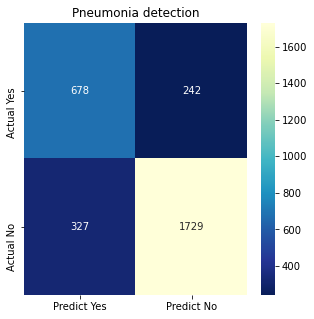

In [37]:
y_predval_baseunet = []
y_trueval_baseunet = []
#recreating the model as i had trained these model again by transfer learning. 
baseunetmodel = createBaseModel()
baseunetmodel.load_weights('baseunet_e15.h5')
 
for imgs, msks in val_gen:
    # predict batch of images
    preds = baseunetmodel.predict(imgs)
    
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        #  detect Pneumonia in mask actual & predicted
        y_trueval_baseunet.append(detectandMask(msk, False))
        y_predval_baseunet.append(detectandMask(pred))
        

printConfusionMatrix('Base UNet Model', y_trueval_baseunet, y_predval_baseunet)

<font color='blue' ><font size=4><b>Predict Pneumonia on Test set</b></font><br> 
Predict Pneumonia cases in the test set using the base CNN model. I am not be able to verify or compare them as we dont have groundtruth table for test dataset.

In [38]:
cnnBase_maskpred = baseunetmodel.predict(test_gen, steps=300)
ytestpred_baseunet =[]
for mask in cnnBase_maskpred:
    ytestpred_baseunet.append(detectandMask(mask))

print('Pneumonia present: (0 - Normal, 1 - Pneumonia)', np.unique(ytestpred_baseunet, return_counts=True))

Pneumonia present: (0 - Normal, 1 - Pneumonia) (array([0, 1]), array([2186,  814]))


<font color='blue' ><font size=4><b>3.2 Transfer Learning 1</b></font><br> 
    Print the evaluation metrics of the Model which predicts the segmentation w.r.to the Validation set. Only the entries with 'segmentation boundaries predicted' are considered as Pneumonia cases. Other entries are marked as Normal.

Transfer Learning
-------------------
Validation Accuracy:  0.8081317204301075
Validation Precision:  0.6739780658025922
Validation Recall:  0.7347826086956522
Validation F1-Score:  0.703068122724909


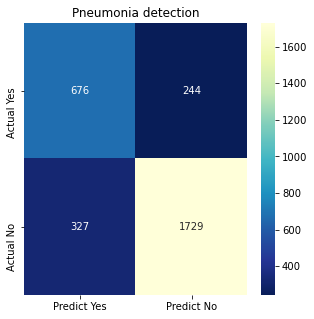

In [35]:
y_predval_cnn_tl1 = []
y_trueval_cnn_tl1 = []

 
for imgs, msks in val_gen:
    # predict batch of images
    preds = cnnmodel_tl1.predict(imgs)
    
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        #  detect Pneumonia in mask actual & predicted
        y_trueval_cnn_tl1.append(detectandMask(msk, False))
        y_predval_cnn_tl1.append(detectandMask(pred))
        

printConfusionMatrix('Transfer Learning', y_trueval_cnn_tl1, y_predval_cnn_tl1)

<font color='blue' ><font size=4><b>Predict Pneumonia on Test set</b></font><br> 
Predict Pneumonia cases in the test set using the transfer learning CNN model which predicts the segmentation. We may not be able to verify or compare them as we dont have groundtruth table for test dataset.

In [39]:
cnn_tl1_maskpred = cnnmodel_tl1.predict(test_gen, steps=300)
ytestpred_cnn_tl1 =[]
for mask in cnn_tl1_maskpred:
    ytestpred_cnn_tl1.append(detectandMask(mask))

print('Pneumonia present: (0 - Normal, 1 - Pneumonia)', np.unique(ytestpred_cnn_tl1, return_counts=True))

Pneumonia present: (0 - Normal, 1 - Pneumonia) (array([0, 1]), array([2186,  814]))


<font color='blue' ><font size=4><b>3.3 Transfer Learning 2</b></font><br> 
    Print the evaluation metrics of the Model which predicts both classification and segmentation w.r.to the Validation set. Only the entries with 'segmentation boundaries predicted' are considered as Pneumonia cases. Other entries are marked as Normal. In this case the model also predicts the pneumonia cases. Evaluation metrics for both cases are printed

Transfer Learning 2: 
-------------------
Validation Accuracy:  0.7960349462365591
Validation Precision:  0.6413730803974707
Validation Recall:  0.7717391304347826
Validation F1-Score:  0.7005426739023186


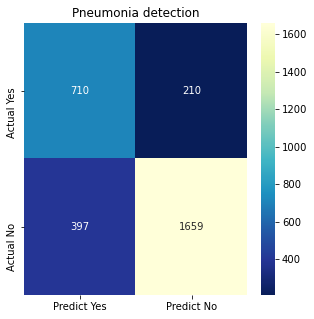

Transfer Learning 2: Classification
-------------------
Validation Accuracy:  0.8185483870967742
Validation Precision:  0.7785923753665689
Validation Recall:  0.5771739130434783
Validation F1-Score:  0.6629213483146068


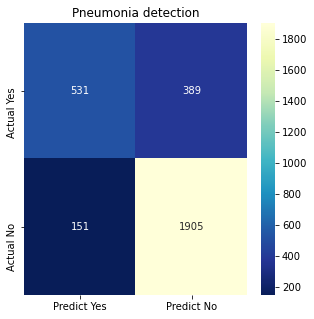

In [41]:
y_predval_cnn_tl2 = []
y_trueval_cnn_tl2 = []
y_predlblval_cnn_tl2 = []
y_truelblval_cnn_tl2 = []
 
for imgs, msks in val_gen_both:
    # predict batch of images
    preds = cnnmodel_tl2.predict(imgs)
    
    # loop through batch
    for img,lbl, msk, predl,predm in zip(imgs,msks[0], msks[1], preds[0], preds[1]):
        y_truelblval_cnn_tl2.append(np.argmax(lbl))
        y_predlblval_cnn_tl2.append(np.argmax(predl))
        
        #  detect Pneumonia in mask actual & predicted
        y_trueval_cnn_tl2.append(detectandMask(msk, False))
        y_predval_cnn_tl2.append(detectandMask(predm))
        

printConfusionMatrix('Transfer Learning 2: ', y_trueval_cnn_tl2, y_predval_cnn_tl2)

printConfusionMatrix('Transfer Learning 2: Classification', y_truelblval_cnn_tl2, y_predlblval_cnn_tl2)

<font color='blue' ><font size=4><b>Predict Pneumonia on Test set</b></font><br> 
Predict Pneumonia cases in the test set using the transferlearning CNN model which predicts both classification and segmentation. We get 2 different output from one from classification and other from segmentation. We may not be able to verify or compare them as we dont have groundtruth table for test dataset.

In [42]:
cnn_tl2_maskpred = cnnmodel_tl2.predict(test_gen_both, steps=300)
ytestpred_cnn_tl2 =[]
ytestpred_cnn_tl2_lbl =[]
for  lbl, mask in zip (cnn_tl2_maskpred[0], cnn_tl2_maskpred[1]):
    ytestpred_cnn_tl2.append(detectandMask(mask))
    ytestpred_cnn_tl2_lbl.append(np.argmax(lbl))

print('Pneumonia present(From BBox): (0 - Normal, 1 - Pneumonia)', np.unique(ytestpred_cnn_tl2, return_counts=True))
print('Pneumonia present(From Classification): (0 - Normal, 1 - Pneumonia)', np.unique(ytestpred_cnn_tl2_lbl, return_counts=True))

Pneumonia present(From BBox): (0 - Normal, 1 - Pneumonia) (array([0, 1]), array([2028,  972]))
Pneumonia present(From Classification): (0 - Normal, 1 - Pneumonia) (array([0, 1]), array([2501,  499]))


<font color='blue' ><font size=4><b>3.4 ResNet Model:</b></font><br> 
    Print the evaluation metrics of the ResNet Model w.r.to the Validation set. Only the entries with 'segmentation boundaries predicted' are considered as Pneumonia cases. Other entries are marked as Normal.

ResNet Model
-------------------
Validation Accuracy:  0.5880376344086021
Validation Precision:  0.4203125
Validation Recall:  0.8771739130434782
Validation F1-Score:  0.5683098591549296


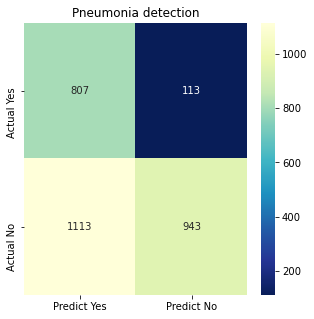

In [43]:
y_predval_resnet = []
y_trueval_resnet = []

 
for imgs, msks in val_gen:
    # predict batch of images
    preds = resnetmodel.predict(imgs)
    
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        #  detect Pneumonia in mask actual & predicted
        y_trueval_resnet.append(detectandMask(msk, False))
        y_predval_resnet.append(detectandMask(pred))
        

printConfusionMatrix('ResNet Model', y_trueval_resnet, y_predval_resnet)

<font color='blue' ><font size=4><b>Predict Pneumonia on Test set</b></font><br> 
Predict Pneumonia cases in the test set using the ResNet model which predicts the segmentation. We may not be able to verify or compare them as we dont have groundtruth table for test dataset.

In [44]:
resnet_maskpred = resnetmodel.predict(test_gen, steps=300)
ytestpred_resnet =[]
for mask in resnet_maskpred:
    ytestpred_resnet.append(detectandMask(mask))

print('Pneumonia present: (0 - Normal, 1 - Pneumonia)', np.unique(ytestpred_resnet, return_counts=True))

Pneumonia present: (0 - Normal, 1 - Pneumonia) (array([0, 1]), array([1129, 1871]))


<font color='blue' ><font size=4><b>3.5 Deep UNET Model:</b></font><br> 
    Print the evaluation metrics of the deepunet Model w.r.to the Validation set. Only the entries with 'segmentation boundaries predicted' are considered as Pneumonia cases. Other entries are marked as Normal.

In [ ]:
y_predval_deepunet = []
y_trueval_deepunet = []

 
for imgs, msks in val_gen:
    # predict batch of images
    preds = unetmodel.predict(imgs)
    
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        #  detect Pneumonia in mask actual & predicted
        y_trueval_deepunet.append(detectandMask(msk, False))
        y_predval_deepunet.append(detectandMask(pred))
        

printConfusionMatrix('Deep Unet: ', y_trueval_deepunet, y_predval_deepunet)

In [ ]:
deepunet_maskpred = unetmodel.predict(test_gen, steps=300)
ytestpred_deepunet =[]
for mask in deepunet_maskpred:
    ytestpred_deepunet.append(detectandMask(mask))

print('Pneumonia present: (0 - Normal, 1 - Pneumonia)', np.unique(ytestpred_deepunet, return_counts=True))

<font color='red' ><font size=3>Unfortunately I missed to execute the above 2 blocks. I have executed them separetely and the output is incorporated here. Please refer the DeepUNet.html<br>



<font color='blue' ><font size=3>While setting up the yolo model, my anaconda installation is corrupted. Due to lack of time, I could not try YOLO and Faster-RCNN. But for my learning purpose, I would like to try them after completing this project</font><br>    


<font color='blue' ><font size=4><b>Insights:</b></font><br><br>
The below table displays the evaluation metrics calculated for all the different models. I had consolidated the IoU loss, Mean loss and Accuracy for both training and validation dataset. I missed to capture dice-coefficent while training the models. So i calculated the dice-coefficent for validation set after training the model.<br><br>

 
|Model	|Train <br>Accuracy|Train <br>Mean Iou|Train <br>loss|Validation<br> Accuracy|Validation<br> Dice Coefficient	|Validation<br> Mean IoU|Validation<br> loss|
|:--|---|---|---|---|---|---|---|
|Base UNet |0.97	|0.70|0.40|0.96 	|0.54	|0.68	|0.39	|
|Transfer Learning 1 - Base model(freeze the weights) + Conv & dense layer	|0.97 	|0.73|0.61|0.97	|0.57	|0.69	|0.58	|
|Transfer Learning 2	- Base model + seg model <br>+ class model |0.98<br>0.86	| |0.96|0.96<br>0.82	|0.06	| 	|1.06|
|ResNet	|0.95	|0.32 |74.80|0.94	|0.33	|0.37	|27.09	|
|Deep Unet|0.97 	|0.67|0.70|0.96 	|0.50	|0.70	|0.66	|

<br><br>Segmentation area is available only when Pneumonia infection present in the image. With this assumption, I had classified Pneumonia cases from the predicted segmentation area. The below table shows the evaluation metrics (TP,TN, FN, FP, Accuracy, Precision, Recall and F1-Score) for each model.
    
|Model	|TP	|FN|FP|	TN	|Accuracy	|Precision|	Recall	|F1-score|Testset<br>classification<br>Normal, Pneumonia|
|:--|---|---|---|---|---|---|---|---|---|
|Base UNet |678	|242	|327	|1729	|0.81	|0.67|0.73|0.70|2186, 814|
|Transfer Learning 1 - Base model(freeze the weights) + Conv & dense layer	|676	|244	|327	|1729	|0.81	|0.67|0.73|0.70|2186, 814|
|Transfer Learning 2	- Base model + seg model <br>+ class model |710<br>531	|220<br>389	|397<br>151	|1659<br>1905	|0.80<br>0.81	|0.64<br>0.77|0.77<br>0.58|0.70<br>0.66|2028,972<br>2501,499|
|ResNet	|807	|113	|1113	|943	|0.58	|0.42|0.88|0.57|1129, 1871|
|Deep Unet|628	|292	|251	|1805	|0.82|0.71|0.68|0.70|2266, 734|
    
The performance of each model could be súmmarized as below:   
1. Base UNet: This model has the least number of trainable parameters and that is big advantage of this model. It has a perfect balance of low training time and best performance.
2. Transfer Learning 1: The Transfer learning 1 model showed similar results compared with the Base UNet model. .
3. Transfer Learning 2: As mentioned earlier, I have trained this model to understand the training of both segmentaion and classification. Though the performance of the segmentation model is good as compared to classification model, the Output from the segmentation model and classification model are not matching. 
4. Resnet: This model was suggested by the mentor. Performance of this model is not good compared to the Base Unet model. I could have increased the resnet blocks to improve the performance. But with limited computing memory, I was unable to increase the resnet blocks. 
5. Deep UNet: With deeper convolution blocks, the performance is comparable to the base Unet model. While visually comparing the segmentation, I could see that the identified segmentation is closer to the original. I will consider this model for further analysis.

<font color='blue' ><b><font size=4>b. Report the recommendations, summarize the project and mention identified next steps </font><b><br>
    

<font color='blue'><font size=4> <b>Recommendations: </b></font>
    
From my above analysis, I recommend the Base Unet model and the deep Unet model.

1. Base Unet model is simple with approximately 97k trainable parameters and predicts results with ~97% accuracy with fewer False Negative cases. But, in some cases, the lung opacity bounding boxes are not very accurate with original. 
This model would therefore be more suitable for those scenarios where the clincians needs to save time to focus his time only on potential pneumonia cases. This model can be used as a guide for the clincians. Re-training this model with additional dataset is easier due to the simplicity of this model.

2. Deep Unet model is more complex with approx 250k trainable parameter and predicts results with ~97% accuracy. The accuracy of bounding boxes is much better with this model, hence i would recommend this model for predicting the infected area. Though model misses few cases, the lung opacity which were identified by this model are more closer to the original lung opacity. This can be confirmed by visual examination. 
    

<font color='blue' >**Summary:**<br>
    
The Objective of the project is to build an efficient (Low false positives) algorithm to detect a visual signal 
for pneumonia by monitoring the lung opacity in chest radiographs. A faster, correct diagnosis of Pnemonia would 
result in reduced fatalities.<br>

<b><u><i>EDA Analysis:</i></u></b><br>
a. Dataset consists of DICOM files of the Chest X-Ray in 2 different set (train and test dataset). <br>
b. Label and Classification table contains multiple entries for some Patient IDs. They are not duplicate information. 
This depicts that multple infected area present in single image. <br>
c. In CXR, Positioning of younger patients are not uniform. I may have to perform Data augumentation technique to resolve this.<br>
d. 94% of the samples belongs to the Patients who are in the Age group 5-70 years. But fatality statistics indicate 
that patients in the age group below 5 and above 70 are more likely to die from Pnemonia. Irrespective of age group,
the rate of Pnemonia risk with in the age group is same. As a conclusion Age is not a key criteria.<br>
e. With in Male and Female group, the rate of Pnemonia risk is same. So, Sex does not have any influence on the classification<br><br>
Outcome of EDA analysis:
    
|Classifiations|	Target/Pnemonia|	Infected Area	|Remarks|
|:--|--:|:--|:--|
|Normal|	0	|No|CXR Objservation is normal.<br> No Lung opacity present.<br> This implies that there is no infected area thus No Area coordinates stored  instead nan is present. |
|No Lung Opacity / Not Normal 	|0	|No	|CXR Objservation is Not normal.<br> No Lung opacity present. <br>This implies that there is no lung infection but the CXR shows some abnormalities. This abnormalities could be due to muliple factors like bleeding, pulmonary edema(fluid overload), atelectasis(volume loss), Post radiation , lung cancer or surgical changes or accumalation of fluid in the pleural space(outside the lungs). <br>Since this abnormalities are not related to Pnemonia, no Area coordinates are stored instead nan is present.  |
|Lung Opacity	|1	|Yes(can be multiple)	| CXR shows Lung opacity and this indicates that Patients have been affected by Pnemonia. <br>In some images, Opacity presents in multiple location. Respective area coordinates are captured and stored, so multiple entries present for the same image/patientID in the label file. <br>Currently the area is stored as an Array. example [[x,y,width,height][x,y,width, height]]. Based on the model I choose, I will update this structure.|

As per the Project brief, the objective is to find Pneumonia affected area (bounding box) in the given CXR  which can guide the clinicians. This needs a Image segmentation model rather than a classification model.    
  
<b><u><i>Data Preprocessing:</i></u></b><br>
Dataset is preprocessed to convert the DICOM files to .png files and the image size is scaled down from 1024 X 1024 to 256 X 256. This process helps in reducing the memory consumption while training and testing.<br>
Split the resized dataset into balanced train and validation(10%) dataset. <br>

<b><u><i>Custom Generator class:</i></u></b><br>
Created a custom generator class to handle the large dataset. It provides the data in batches to reduce the resource consumption. The class can return return multiple label information that can support both classification and segmentation. The possible return values are:<br>
a. Masked image with embedded bounding box .<br>
b. One-hot-encoded classification label, which indicates only 2 classifications: Normal or Pneumonia.<br>
c. Both of the above information.<br>

This adaptation is motivated to exploit the faster R-CNN model which expects classification and segmentation labels. 
Created train, validation and test generator objects from the split dataset .<br>
Defined different losses - IOU Loss, IOU and Binary CrossEntropy<br>
    
<b><u><i>Inital model building:</i></u></b><br>  
A simple model was created based on UNET architecture which takes 224 X 224 grayscale images as input and output. I had used gray scale to reduce the memory consumption.<br>
<u>Model parameter:</u><br>
Optimizer: Adam<br>
Loss : IOU <br>
Metrics : Mean IOU , accuracy<br>
The evaluation metrics (Loss, Accuracy and Mean Iou) were plotted. For each Epoch, the model accuracy improved as the loss was reducing. So i deduce that the model was trained in the correct way. After executed the model with the Validation dataset, the results were displayed as an overlayed image with the true boundaries and predicted boundaries for a visual inspection.<br>
    
<b><u><i>Improvement steps :</i></u></b><br>
a. Base UNet: I have tried finetuning the base model by modifying the hyperparameter.<br>
    Epoch: Increasing the epochs did not have significant impact on the performance. So i used only 5 epoch for further training.<br>
    Activation: initial model uses 'adam', I tried with 'sgd' and performance slightly deterioted.<br>
    Loss functions: Since the model predicts segmentation, I had initally used IoU loss. I had used binary crossentropy but the performance did not improve. <br>

b. Transfer Learning (with additional layers): Next I performed transfer learning. I had added few more convolution layers to the base Unet model. I had loaded the pretrained weights and trained the model again. This change did not show any difference in the performance.
    
c. Transfer learning (Classification + Segmentation model): I am aware that without ROI layer, training both classification and segmentation model together may not give better result. I had tried creating this model for my learning and understanding purpose. Though segmentation model performed better, the classification model produces poor result. And there were lot of discrepancies between them. So i did not pursue this model

d. ResNet: As suggested by the mentor, I tried this model. I had used a predefined resnet block to see the results. 
Though the accuracy was at par with the UNet model, the detected area is not very accurate. I could have 
finetuned this model by increasing the depth of the layers and increasing the resnet blocks. Due to lack of time and limited computing resources, i had not pursued it further.
    
e. Deep UNet: Since Unet model performance was better compared to other models, I added 8 deeper convolutional blocks in each layers to the same unet model. I trained this model for 15 epochs to improve the performance. Though there were slight reduction in overall F1-score, the predicted lung opacity areas matched much closer to the original lung opacity.
    
<u><b>Model Performance:</b></u><br>
    
|Model	|Train <br>Accuracy|Train <br>Mean Iou|Train <br>loss|Validation<br> Accuracy|Validation<br> Dice Coefficient	|Validation<br> Mean IoU|Validation<br> loss|
|:--|---|---|---|---|---|---|---|
|Base UNet |0.97	|0.70|0.40|0.96 	|0.54	|0.68	|0.39	|
|Deep Unet model|0.97 	|0.67|0.70|0.96 	|0.50	|0.70	|0.66	|

    
|Model	|TP	|FN|FP|	TN	|Accuracy	|Precision|	Recall	|F1-score|Testset<br>classification<br>Normal, Pneumonia|
|:--|---|---|---|---|---|---|---|---|---|
|Base UNet |678	|242	|327	|1729	|0.81	|0.67|0.73|0.70|2186, 814|
|Deep Unet model|628	|292	|251	|1805	|0.82|0.71|0.68|0.70|2266, 734|
   
<b><u><i>Next identified steps:</i></u></b><br>
a. I have shortlisted 2 models(Simple Unet, Deep Unet model). I could get expert(or SME) review on selecting one of this model.<br>
b. DeepUnet model misses to identify some Pneumonia cases. I could improve this by performing following steps:<br>
    <font color='blue' >- While training, I observed that the increasing the convolution blocks significantly improves the performance. Current deep UNET model uses 8 layers of convolution block. I can increase this to improve the model.<br>
    <font color='blue' >- Brightness of the CXR images which were used for training are not the same.  Also the lung positioning is not uniform in the images. I could perform 'Horizontal and Vertical Shift Augmentation' and 'Brightness Augmentation' techniques<br>
    <font color='blue' >I could not perform these steps due to the resource limitation of my system. <br></font>
c. If I could get training set with more Pneumonia cases, then the model could be trained further which could result better performance.<br>
d. Train the data using advanced pretrained models like Yolo and CheXNet.<br>  
    
<i><u>Reflection:</u></i><br>
    
I built the model from scratch as described in the Project brief. Later the mentor confirmed that use of pretrained model is acceptable. If this information was clearly mentioned in the document, I could have started with CheXNet, faster r-cnn or yolo. <br>
Due to resource limitation, I had trained the models in Kaggle. The kaggle notebook was wierd sometimes. Kaggle does not store the outputs as in Jupyter. I had trained all the model in kaggle and stored them locally. During documentation, I had noticed that all the outputs are lost and I had to perform my training again which costed me lot of time.<br>
    